In [112]:
import torch
from torch import nn
import pandas as pd
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

In [113]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq calcula se dois tensores sao iguais
    acc = (correct / len(y_pred)) * 100
    return acc

In [114]:
n_samples = 1000
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:10], y[:10]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967],
         [-0.4796,  0.6764],
         [-0.0136,  0.8033],
         [ 0.7715,  0.1478],
         [-0.1693, -0.7935],
         [-0.1215,  1.0215]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [115]:
X[:, 0][:5]
X[:, 1][:5]

tensor([ 0.2315,  0.1533,  0.1733,  0.6929, -0.8967])

In [116]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "Labels": y})

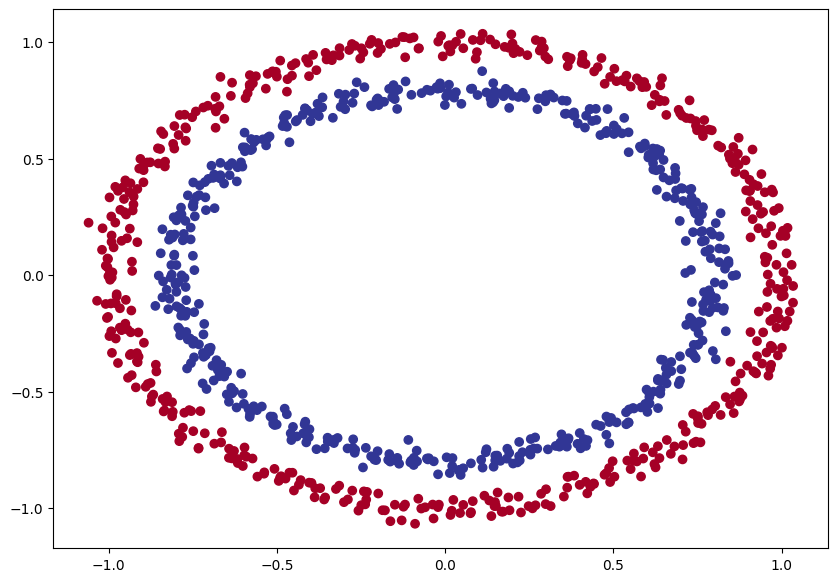

In [117]:
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [119]:
# Make device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cpu'

In [120]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.layer2 = nn.Linear(in_features=16, out_features=16)
        self.layer3 = nn.Linear(in_features=16, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
model_1 = CircleModelV0().to(device)
print(model_1)

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [121]:
loss_fn = nn.BCEWithLogitsLoss()
optm = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [122]:
torch.manual_seed(42)
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
epochs = 1400

for epoch in range(epochs):
    ### Treinando
    # 1. Forward pass
    y_logist = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logist))
    
    # 2. Calculate loss and acc
    loss = loss_fn(y_logist, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    # 3. Zero Grad
    optm.zero_grad()
    
    # 4. Loss Backward
    loss.backward()
    
    # 5. Step
    optm.step()
    
    ### Testando
    model_1.eval()
    with torch.inference_mode():
        # Forward pass
        test_logist = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logist))
        
        # Calculate loss and acc
        test_loss = loss_fn(test_logist, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        
    # Printar dados 
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6975, Accuracy: 50.00% | Test Loss: 0.6978, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.6899, Accuracy: 56.25% | Test Loss: 0.6914, Test Accuracy: 51.50%
Epoch: 200 | Loss: 0.6866, Accuracy: 52.88% | Test Loss: 0.6887, Test Accuracy: 52.00%
Epoch: 300 | Loss: 0.6826, Accuracy: 53.62% | Test Loss: 0.6858, Test Accuracy: 52.50%
Epoch: 400 | Loss: 0.6774, Accuracy: 54.00% | Test Loss: 0.6819, Test Accuracy: 53.50%
Epoch: 500 | Loss: 0.6701, Accuracy: 56.00% | Test Loss: 0.6764, Test Accuracy: 55.50%
Epoch: 600 | Loss: 0.6594, Accuracy: 62.38% | Test Loss: 0.6678, Test Accuracy: 58.00%
Epoch: 700 | Loss: 0.6417, Accuracy: 75.50% | Test Loss: 0.6533, Test Accuracy: 68.50%
Epoch: 800 | Loss: 0.6128, Accuracy: 87.38% | Test Loss: 0.6289, Test Accuracy: 85.00%
Epoch: 900 | Loss: 0.5640, Accuracy: 97.25% | Test Loss: 0.5872, Test Accuracy: 93.00%
Epoch: 1000 | Loss: 0.4822, Accuracy: 99.25% | Test Loss: 0.5170, Test Accuracy: 97.00%
Epoch: 1100 | Loss: 0.3630, Accuracy: 99.75%

In [123]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "01_pytorch_binarycl_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Salvando modelo para {MODEL_SAVE_PATH}")
torch.save(obj=model_1, f=MODEL_SAVE_PATH)

Salvando modelo para models\01_pytorch_binarycl_workflow_model_1.pth


### Multiclass classification

In [124]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)

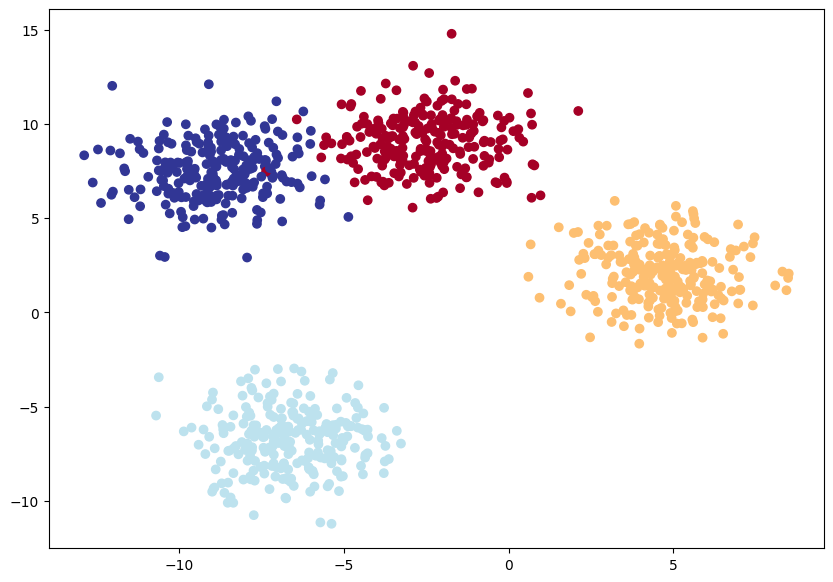

In [125]:
# Separate train and test data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# Plot the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [126]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [127]:
class MultiClassificationModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)
model_2 = MultiClassificationModel(input_features=NUM_FEATURES,
                                   output_features=NUM_CLASSES,).to(device)
model_2
        

MultiClassificationModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [128]:
loss_fn = nn.CrossEntropyLoss()
optm = torch.optim.SGD(model_2.parameters(),
                       lr=0.1)

In [129]:
torch.manual_seed(42)

epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training model
    model_2.train()
    
    # Forward pass
    y_logist = model_2(X_blob_train)
    y_pred = torch.softmax(y_logist, dim=1).argmax(dim=1)
    
    # Calculate loss and acc
    loss = loss_fn(y_logist, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    # Optim zero grad
    optm.zero_grad()
    # Loss backward
    loss.backward()
    # Optim step
    optm.step()
    ### Testing model
    model_2.eval()
    with torch.inference_mode():
        test_logist = model_2(X_blob_test)
        test_pred = torch.softmax(test_logist, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logist, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


In [130]:
MODEL_NAME = "01_pytorch_multiclasscl_workflow_model_02.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Salvando modelo em {MODEL_SAVE_PATH}")
torch.save(obj=model_2, f=MODEL_SAVE_PATH)

Salvando modelo em models\01_pytorch_multiclasscl_workflow_model_02.pth
